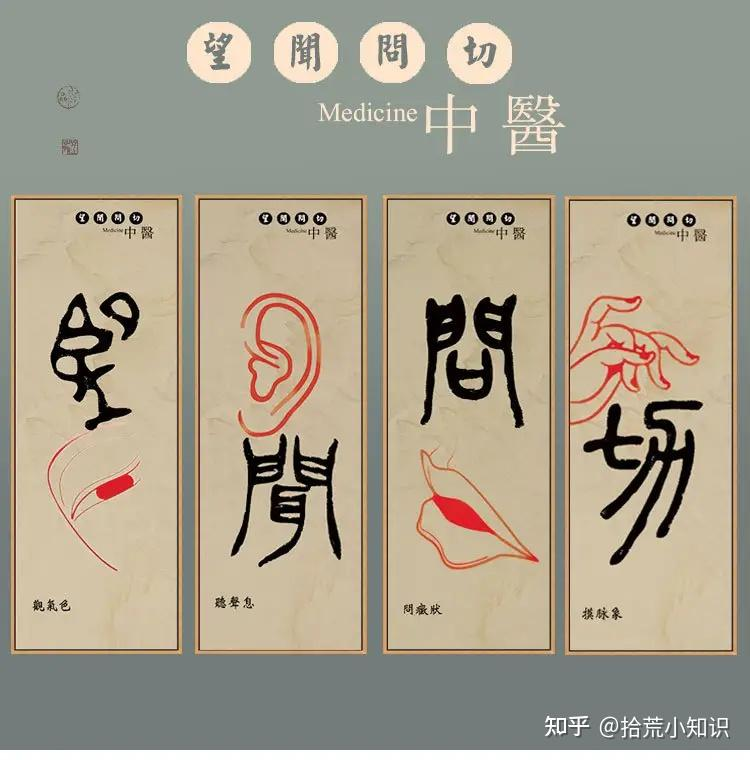]

# 一、觀氣色   
# 基于图像数据、MedGemma-4B和QLoRA微调训练模拟中医望诊青少年抑郁症
# Fine-tune MedGemma with Hugging Face

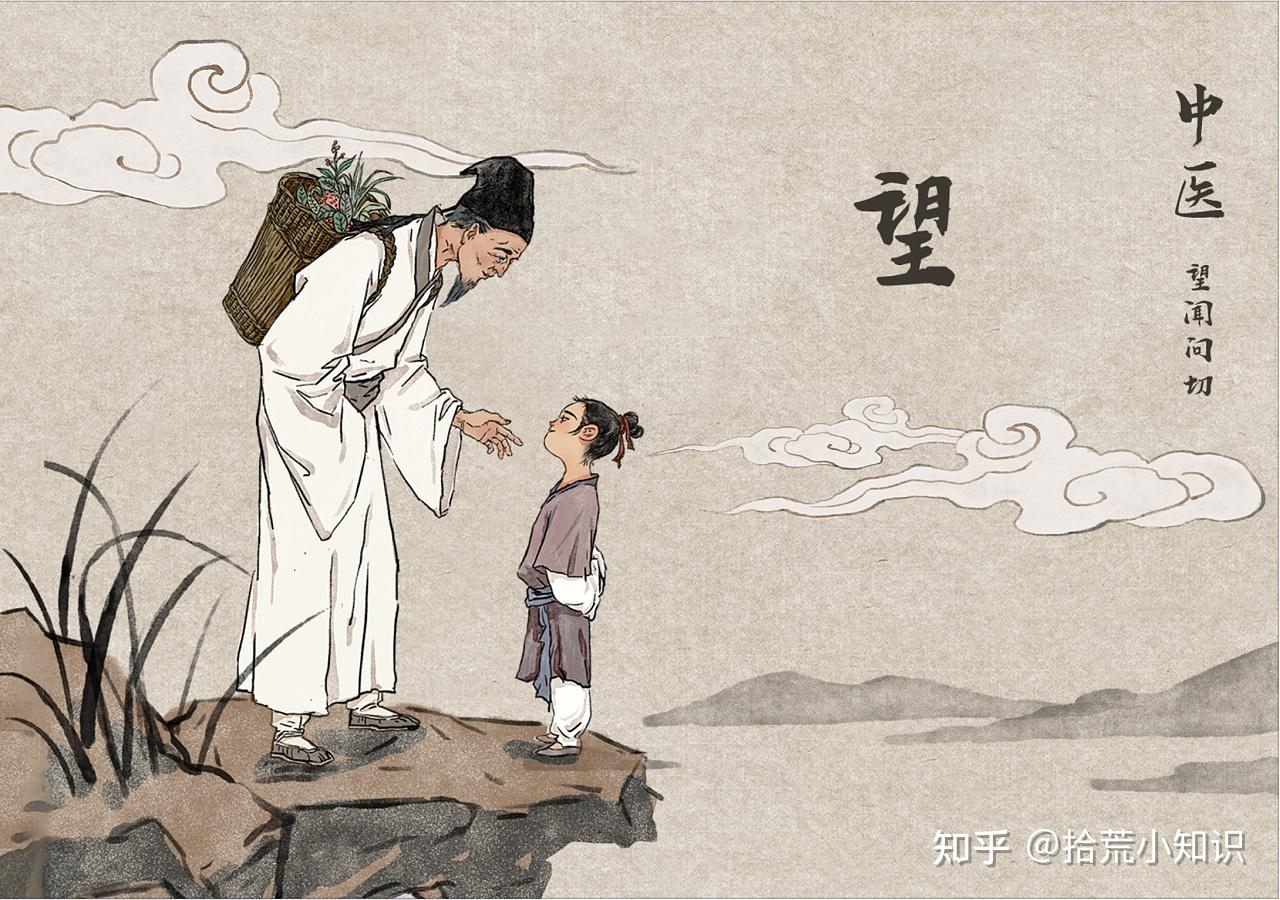]

In [1]:
# Install dependencies
! pip install --upgrade --quiet bitsandbytes datasets evaluate peft tensorboard transformers trl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 MB 25.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 411.1/411.1 kB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 78.1 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 88.8 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 366.3/366.3 kB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.8 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 16.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/12

### Load model from Hugging Face Hub 加载模型

Initialize the quantization configuration and load the model.  
初始化量化配置并加载模型。  

In [ ]:
import os
os.environ['HF_TOKEN'] = ''

from huggingface_hub import login
login(token=os.environ['HF_TOKEN'])

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [2]:
import torch
from transformers import AutoProcessor, AutoModelForImageTextToText, BitsAndBytesConfig

model_id = "google/medgemma-4b-it"

2025-06-08 16:26:10.512607: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749399970.919695      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749399971.037823      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:

# # Check if GPU supports bfloat16
# if torch.cuda.get_device_capability()[0] < 8:
#     raise ValueError("GPU does not support bfloat16, please use a GPU that supports bfloat16.")
# ValueError: GPU does not support bfloat16, please use a GPU that supports bfloat16.

model_kwargs = dict(
    attn_implementation="eager",
    torch_dtype=torch.bfloat16,
    device_map="auto",
)


In [6]:
# Install dependencies
! pip install --upgrade --quiet bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 MB 26.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 83.2 MB/s eta 0:00:00:00:0100:01


In [9]:
!pip install -U bitsandbytes

In [17]:
# Install dependencies
! pip install --upgrade --quiet bitsandbytes evaluate peft transformers trl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 366.3/366.3 kB 6.7 MB/s eta 0:00:00a 0:00:01


In [7]:
model_kwargs["quantization_config"] = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=model_kwargs["torch_dtype"],
    bnb_4bit_quant_storage=model_kwargs["torch_dtype"],
)

In [18]:
model = AutoModelForImageTextToText.from_pretrained(model_id, **model_kwargs)
processor = AutoProcessor.from_pretrained(model_id)

ImportError: Using `bitsandbytes` 4-bit quantization requires the latest version of bitsandbytes: `pip install -U bitsandbytes`

In [2]:
import tensorflow as tf

E0000 00:00:1749390512.431320      10 common_lib.cc:612] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="local"
=== Source Location Trace: ===
learning/45eac/tfrc/runtime/common_lib.cc:230


In [3]:
import torch

In [ ]:
from transformers import AutoProcessor, AutoModelForImageTextToText, BitsAndBytesConfig

In [ ]:


model_id = "google/medgemma-4b-pt"
# model_id = "google/gemma-3-4b-pt"

# Check if GPU supports bfloat16
if torch.cuda.get_device_capability()[0] < 8:
    raise ValueError("GPU does not support bfloat16, please use a GPU that supports bfloat16.")

model_kwargs = dict(
    attn_implementation="eager",
    torch_dtype=torch.bfloat16,
    device_map="auto",
)

model_kwargs["quantization_config"] = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=model_kwargs["torch_dtype"],
    bnb_4bit_quant_storage=model_kwargs["torch_dtype"],
)

model = AutoModelForImageTextToText.from_pretrained(model_id, **model_kwargs)
model = AutoModelForImageTextToText.from_pretrained(model_id)
processor = AutoProcessor.from_pretrained(model_id)

# Use right padding to avoid issues during training
processor.tokenizer.padding_side = "right"

In [ ]:
import tensorflow as tf
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification, AutoFeatureExtractor

# 替换为支持 TensorFlow 的模型（假设存在）
model_id = "google/medgemma-4b-pt"  # 假设存在 TensorFlow 版本

E0000 00:00:1749390022.942842      10 common_lib.cc:612] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="local"
=== Source Location Trace: ===
learning/45eac/tfrc/runtime/common_lib.cc:230


In [ ]:
# import torch
from transformers import AutoProcessor, AutoModelForImageTextToText, BitsAndBytesConfig

model_id = "google/medgemma-4b-pt"
# model_id = "google/gemma-3-4b-pt"

E0000 00:00:1749389324.669358      10 common_lib.cc:612] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="local"
=== Source Location Trace: === 
learning/45eac/tfrc/runtime/common_lib.cc:230


In [ ]:

# Check if GPU supports bfloat16
if torch.cuda.get_device_capability()[0] < 8:
    raise ValueError("GPU does not support bfloat16, please use a GPU that supports bfloat16.")


In [ ]:

model_kwargs = dict(
    attn_implementation="eager",
    torch_dtype=torch.bfloat16,
    device_map="auto",
)


In [ ]:

model_kwargs["quantization_config"] = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=model_kwargs["torch_dtype"],
    bnb_4bit_quant_storage=model_kwargs["torch_dtype"],
)


In [ ]:

model = AutoModelForImageTextToText.from_pretrained(model_id, **model_kwargs)



In [ ]:
model = AutoModelForImageTextToText.from_pretrained(model_id)


In [ ]:
processor = AutoProcessor.from_pretrained(model_id)

In [ ]:

# Use right padding to avoid issues during training
processor.tokenizer.padding_side = "right"

In [ ]:
代码已完成，需要测试！！！！！！
# 在图像和文本数据集上使用Hugging Face库对MedGemma进行微调，以完成视觉任务。使用Hugging Face的Transformer强化学习（TRL）库，通过有监督微调（SFT）来训练模型，同时利用量化低秩自适应（QLoRA）来降低计算成本，同时保持高性能。
# 要求使用支持bfloat16数据类型的GPU，并且具有至少40GB的内存。可以在Google Colab中使用A100 GPU运行此笔记本：在Colab窗口的右上角，选择▾（其他连接选项）。选择更改运行时类型。在硬件加速器下，选择A100 GPU.
from transformers import AutoTokenizer, AutoModelForCausalLM

# 加载MedGemma 27B文本模型（假设通过Hugging Face）
tokenizer = AutoTokenizer.from_pretrained("google/medgemma-4b-pt")
model = AutoModelForCausalLM.from_pretrained("google/medgemma-4b-pt")

In [ ]:
import torch
from transformers import AutoProcessor, AutoModelForImageTextToText, BitsAndBytesConfig

model_id = "google/medgemma-4b-pt"

# Check if GPU supports bfloat16
if torch.cuda.get_device_capability()[0] < 8:
    raise ValueError("GPU does not support bfloat16, please use a GPU that supports bfloat16.")

model_kwargs = dict(
    attn_implementation="eager",
    torch_dtype=torch.bfloat16,
    device_map="auto",
)

model_kwargs["quantization_config"] = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=model_kwargs["torch_dtype"],
    bnb_4bit_quant_storage=model_kwargs["torch_dtype"],
)

model = AutoModelForImageTextToText.from_pretrained(model_id, **model_kwargs)
processor = AutoProcessor.from_pretrained(model_id)

# Use right padding to avoid issues during training
processor.tokenizer.padding_side = "right"

E0000 00:00:1749376134.809597      10 common_lib.cc:612] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="local"
=== Source Location Trace: === 
learning/45eac/tfrc/runtime/common_lib.cc:230


# 二、聽聲息
# 基于音频数据、Gemini API和？模拟中医闻诊青少年抑郁症
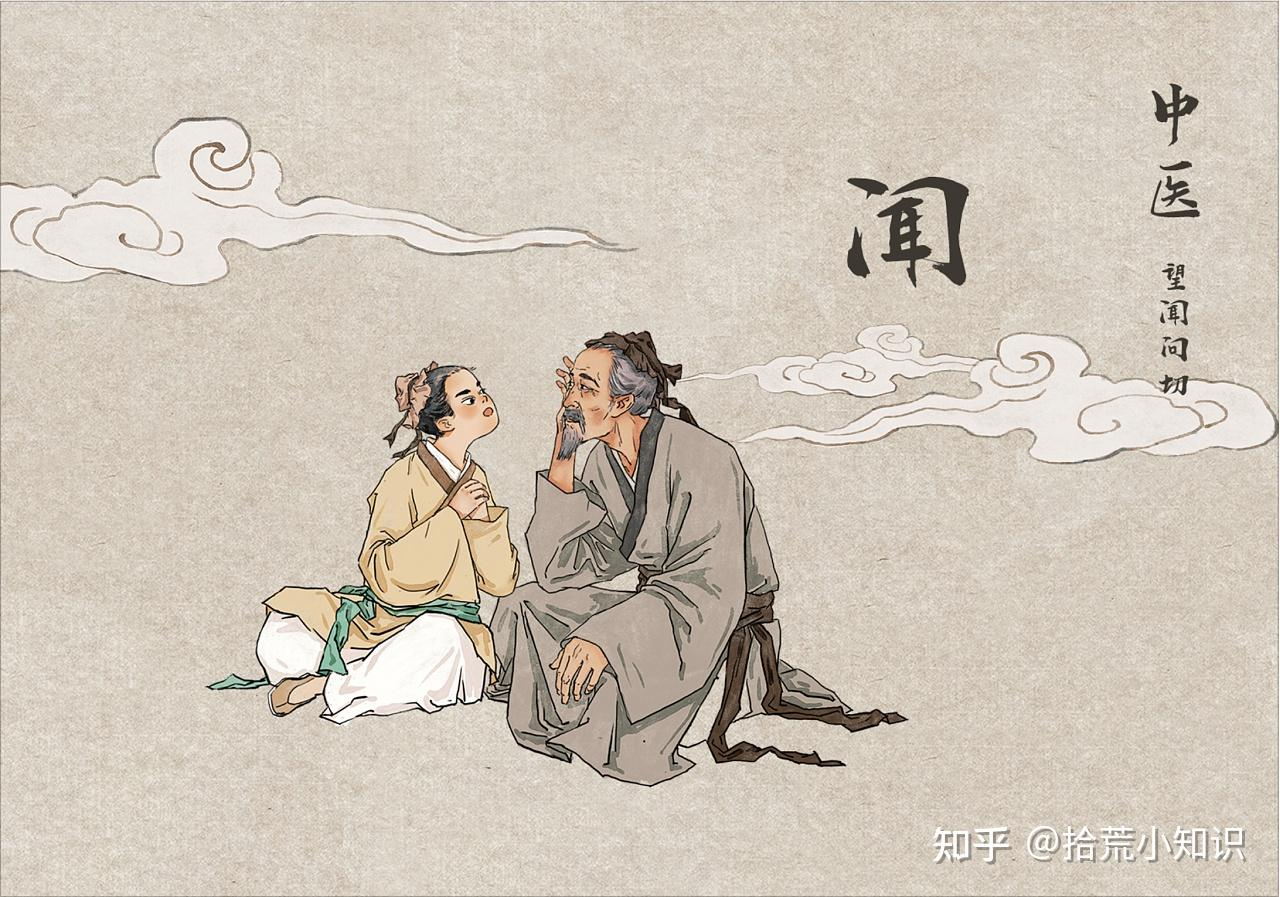]

# 三、問症狀
# 基于文本数据、Gemma3-4B和多模态RAG、提示工程模拟中医问诊青少年抑郁症
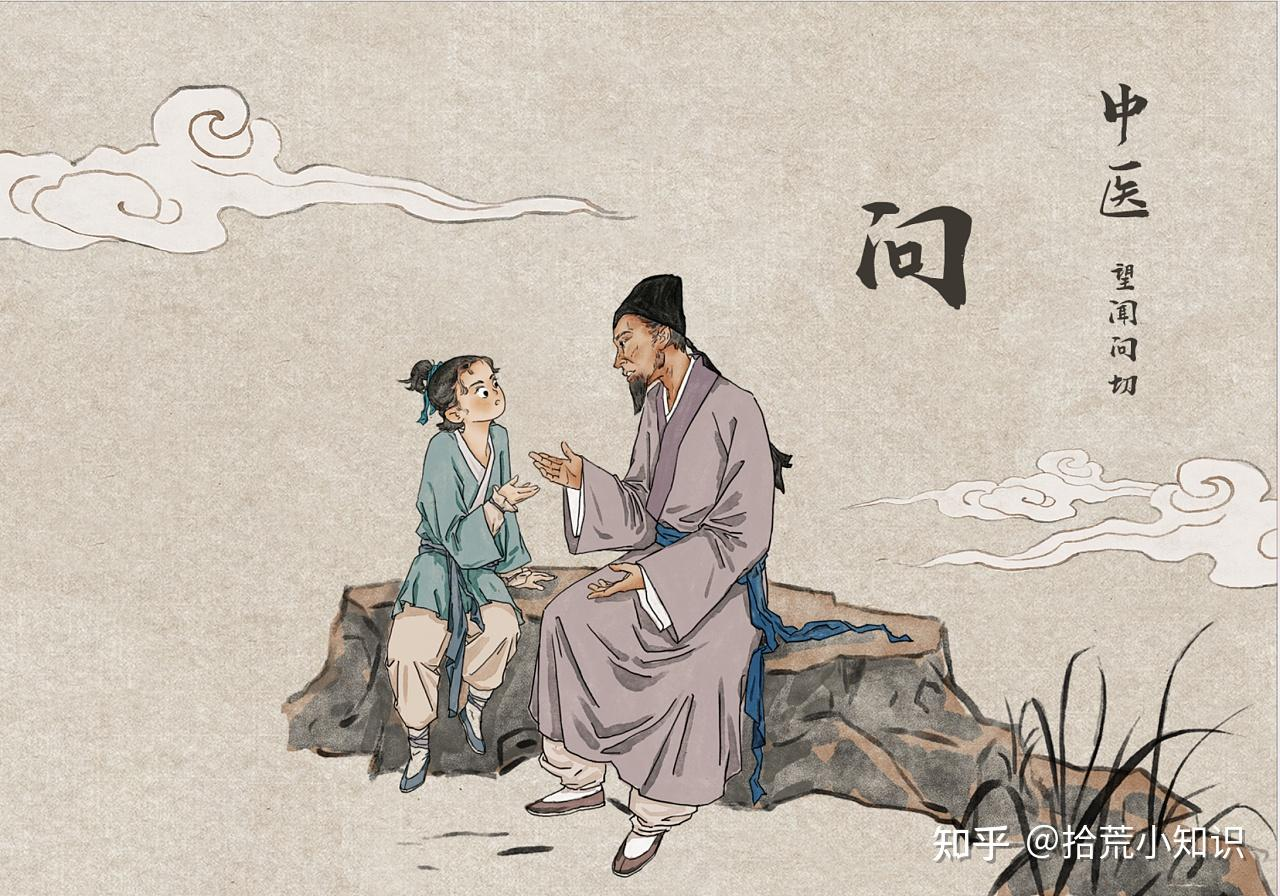]

In [1]:
# 中医问诊+多模态RAG

# 加载Gemma3-1B
# ——4B


/bin/bash: line 1: ollama: command not found


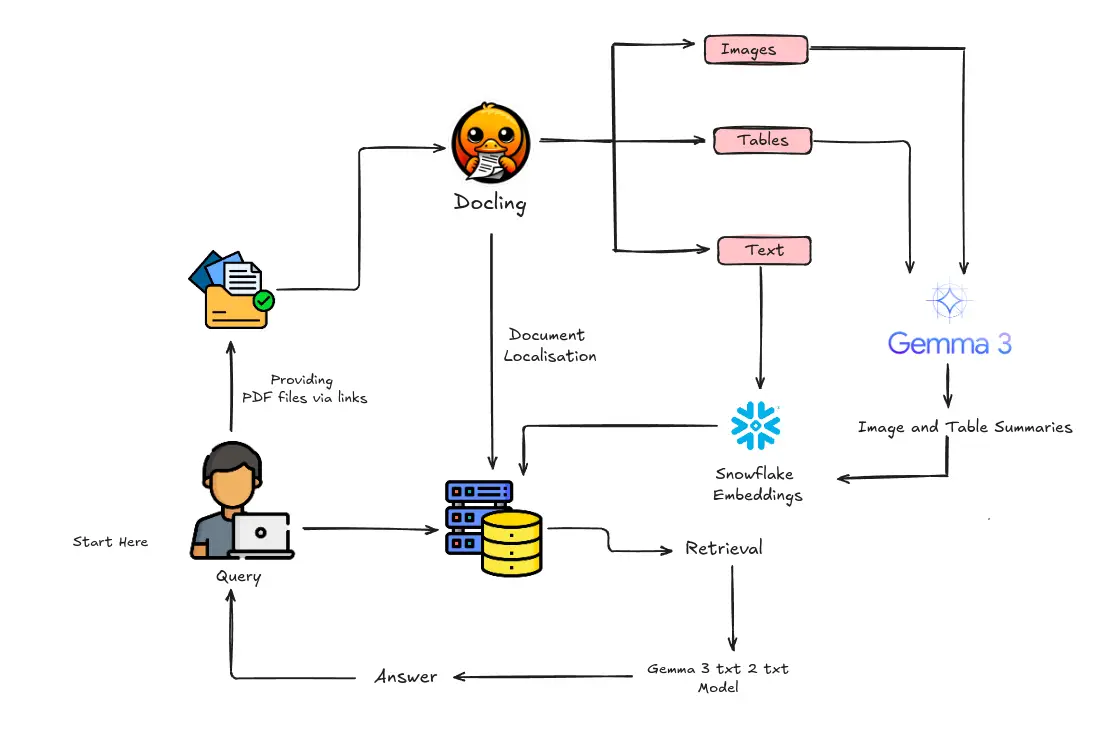]

In [ ]:
# Hugging Face认证步骤对于获取模型工件并确保与 Hugging Face 生态系统的顺畅集成是必要的。
!huggingface-cli login

In [ ]:
!pip install transformers \
    pillow \
    langchain_community \
    langchain_huggingface \
    langchain_milvus \
    docling \
    langchain_ollama

In [ ]:
!pip install -q transformers accelerate

from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

model_name = "google/gemma-3-1b-pt"
# model_name = "google/gemma-3-4b-pt"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch.float16, device_map="auto")

prompt = "Q: What is the capital of France?\nA:"
inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
outputs = model.generate(**inputs, max_new_tokens=50)
print(tokenizer.decode(outputs[0]))

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━ 377.8/664.8 MB 143.1 MB/s eta 0:00:03

In [ ]:
import os
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.vectorstores import InMemoryVectorStore
from langchain_ollama import OllamaEmbeddings
from langchain_ollama.llms import OllamaLLM
from langchain_text_splitters import RecursiveCharacterTextSplitter
# from unstructured.partition.pdf import partition_pdf
# from unstructured.partition.utils.constants import PartitionStrategy
from IPython.display import display, Markdown

In [ ]:
# 设置日志记录对于监控管道操作至关重要：

import logging
logging.basicConfig(level=logging.INFO)

In [ ]:
# Set up HuggingFace embeddings and tokenizer for later use with text processing.
from langchain_huggingface import HuggingFaceEmbeddings
from transformers import AutoTokenizer

embeddings_model_path = "Snowflake/snowflake-arctic-embed-m"
embeddings_model = HuggingFaceEmbeddings(
    model_name=embeddings_model_path,
)
embeddings_tokenizer = AutoTokenizer.from_pretrained(embeddings_model_path)

In [ ]:
# TODO Set up a vision model and processor.
from transformers import AutoProcessor

vision_model_path = "google/gemma-3-4b-it"
vision_model = OllamaLLM(model="gemma3:4b")
vision_processor = AutoProcessor.from_pretrained(vision_model_path)

In [ ]:
# TODO Set up a language model for text tasks using the OllamaLLM.
model_path = "google/gemma-3-4b-it"
model = OllamaLLM(model="gemma3:4b")
tokenizer = AutoTokenizer.from_pretrained(model_path)

In [ ]:
# 使用 Docling 的 DocumentConverter 将 PDF 转换为结构化文档。转换过程涉及从源 PDF 中提取文本、表格和图像：
from docling.document_converter import DocumentConverter, PdfFormatOption
from docling.datamodel.base_models import InputFormat
from docling.datamodel.pipeline_options import PdfPipelineOptions
pdf_pipeline_options = PdfPipelineOptions(
    do_ocr=False,
    generate_picture_images=True,
)
format_options = { InputFormat.PDF: PdfFormatOption(pipeline_options=pdf_pipeline_options) }
converter = DocumentConverter(format_options=format_options)
# Define the sources (URLs) of the documents to be converted.
# "https://arxiv.org/pdf/1706.03762"
sources = [
 "https://www.pwc.com/jm/en/research-publications/pdf/basic-understanding-of-a-companys-financials.pdf"
]
# Convert the PDF documents from the sources into an internal document format.
conversions = { source: converter.convert(source=source).document for source in sources }

In [ ]:
from docling_core.transforms.chunker.hybrid_chunker import HybridChunker
from docling_core.types.doc.document import TableItem
from langchain_core.documents import Document

# Process the converted documents by splitting them into text chunks.
doc_id = 0
texts: list[Document] = []
for source, docling_document in conversions.items():
    # Use a hybrid chunker that leverages the tokenizer to split the document.
    for chunk in HybridChunker(tokenizer=embeddings_tokenizer).chunk(docling_document):
        items = chunk.meta.doc_items
        # Skip chunks that only consist of tables; those will be processed separately.
        if len(items) == 1 and isinstance(items[0], TableItem):
            continue # we will process tables later
        # Combine references from document items.
        refs = " ".join(map(lambda item: item.get_ref().cref, items))
        print(refs)
        text = chunk.text
        document = Document(
            page_content=text,
            metadata={
                "doc_id": (doc_id:=doc_id+1),
                "source": source,
                "ref": refs,
            },
        )
        texts.append(document)

print(f"{len(texts)} text document chunks created")

In [ ]:
# Process tables from the converted documents separately.
from docling_core.types.doc.labels import DocItemLabel

doc_id = len(texts)
tables: list[Document] = []
for source, docling_document in conversions.items():
    for table in docling_document.tables:
        if table.label in [DocItemLabel.TABLE]:
            ref = table.get_ref().cref
            print(ref)
            text = table.export_to_markdown()
            document = Document(
                page_content=text,
                metadata={
                    "doc_id": (doc_id:=doc_id+1),
                    "source": source,
                    "ref": ref
                },
            )
            tables.append(document)

print(f"{len(tables)} table documents created")

In [ ]:
# Import modules to handle image encoding.
import base64
import io
import PIL.Image
import PIL.ImageOps

def encode_image(image: PIL.Image.Image, format: str = "png") -> str:
    """
    Encode a PIL image to a base64 URI.
    This helps to embed images directly into prompts or HTML.
    """
    image = PIL.ImageOps.exif_transpose(image) or image
    image = image.convert("RGB")

    buffer = io.BytesIO()
    image.save(buffer, format)
    encoding = base64.b64encode(buffer.getvalue()).decode("utf-8")
    uri = f"data:image/{format};base64,{encoding}"
    return uri

# Set up a prompt template for processing images.
# Feel free to experiment with this prompt
image_prompt = "If the image contains text, explain the text in the image. The image is: {}"
conversation = [
    {
        "role": "user",
        "content": [
            {"type": "text", "text": image_prompt},
        ],
    },
]

# Apply the vision processor's chat template to the conversation.
vision_prompt = vision_processor.apply_chat_template(
    conversation=conversation,
    add_generation_prompt=True,
)
# Convert vision_prompt to a string if it is a list of integers
vision_prompt = tokenizer.decode(vision_prompt) if isinstance(vision_prompt, list) else vision_prompt

# Process the pictures embedded in the documents.
pictures: list[Document] = []
doc_id = len(texts) + len(tables)
for source, docling_document in conversions.items():
    for picture in docling_document.pictures:
        ref = picture.get_ref().cref
        print(ref)
        image = picture.get_image(docling_document)
        if image:
            encoded_image = encode_image(image)
            # Modify the prompt to include the encoded image
            # Insert the encoded image into the prompt.
            prompt_with_image = vision_prompt.format(encoded_image)
            # Invoke the vision model to generate a description from the image.
            text = vision_model.invoke(prompt_with_image)
            document = Document(
                page_content=text,
                metadata={
                    "doc_id": (doc_id:=doc_id+1),
                    "source": source,
                    "ref": ref,
                },
            )
            pictures.append(document)

print(f"{len(pictures)} image descriptions created")

In [ ]:
import itertools
from docling_core.types.doc.document import RefItem
from IPython.display import display

# Print all created documents
for document in itertools.chain(texts, tables):
    print(f"Document ID: {document.metadata['doc_id']}")
    print(f"Source: {document.metadata['source']}")
    print(f"Content:\n{document.page_content}")
    print("=" * 80)  # Separator for clarity

# Display image descriptions along with the actual image.
for document in pictures:
    print(f"Document ID: {document.metadata['doc_id']}")
    source = document.metadata['source']
    print(f"Source: {source}")
    print(f"Content:\n{document.page_content}")
    docling_document = conversions[source]
    ref = document.metadata['ref']
    picture = RefItem(cref=ref).resolve(docling_document)
    image = picture.get_image(docling_document)
    print("Image:")
    display(image)
    print("=" * 80)  # Separator for clarity

In [ ]:
# 提取和分块内容
# After conversion, we chunk the document into manageable pieces, separating text from tables and images. This segmentation allows each component to be processed independently:
# 转换后，我们将文档分割成可管理的片段，将文本、表格和图像分开。这种分割允许每个组件独立处理：
from docling_core.transforms.chunker.hybrid_chunker import HybridChunker
from docling_core.types.doc.document import TableItem
from langchain_core.documents import Document

# Process the converted documents by splitting them into text chunks.
doc_id = 0
texts: list[Document] = []
for source, docling_document in conversions.items():
    # Use a hybrid chunker that leverages the tokenizer to split the document.
    for chunk in HybridChunker(tokenizer=embeddings_tokenizer).chunk(docling_document):
        items = chunk.meta.doc_items
        # Skip chunks that only consist of tables; those will be processed separately.
        if len(items) == 1 and isinstance(items[0], TableItem):
            continue # we will process tables later
        # Combine references from document items.
        refs = " ".join(map(lambda item: item.get_ref().cref, items))
        print(refs)
        text = chunk.text
        document = Document(
            page_content=text,
            metadata={
                "doc_id": (doc_id:=doc_id+1),
                "source": source,
                "ref": refs,        # "ref": "reference details"
            },
        )
        texts.append(document)

print(f"{len(texts)} text document chunks created")

In [ ]:
# 使用 Milvus 创建向量数据库
import tempfile
from langchain_core.vectorstores import VectorStore
from langchain_milvus import Milvus
db_file = tempfile.NamedTemporaryFile(prefix="vectorstore_", suffix=".db", delete=False).name
vector_db: VectorStore = Milvus(
    embedding_function=embeddings_model,
    connection_args={"uri": db_file},
    auto_id=True,
    enable_dynamic_field=True,
    index_params={"index_type": "AUTOINDEX"},
)

## 构建检索增强生成（RAG）链

In [ ]:
# 1. 提示创建与文档包装
from langchain.prompts import PromptTemplate
prompt = "{input} Given the context: {context}"
prompt_template = PromptTemplate.from_template(template=prompt)

In [ ]:
# 2. 组装 RAG 流程
from langchain.chains.retrieval import create_retrieval_chain
from langchain.chains.combine_documents import create_stuff_documents_chain
combine_docs_chain = create_stuff_documents_chain(
    llm=model,
    prompt=prompt_template,
    document_prompt=PromptTemplate.from_template(template="""\
Document {doc_id}
{page_content}"""),
    document_separator="\n\n",
)
rag_chain = create_retrieval_chain(
    retriever=vector_db.as_retriever(),
    combine_docs_chain=combine_docs_chain,
)

## 执行查询和检索信息

In [ ]:
query = "Explain Three Key Financial Statements Notes"
outputs = rag_chain.invoke({"input": query})
Markdown(outputs['answer'])

In [ ]:
query = "what are the benefits of an annual report?"
outputs = rag_chain.invoke({"input": query})
Markdown(outputs['answer'])

In [ ]:
query = "tell me the Contents of an annual report"
outputs = rag_chain.invoke({"input": query})
Markdown(outputs['answer'])

# 四、摸脈象
# 切诊？Agent？具身智能机器人机器臂机器手灵巧手
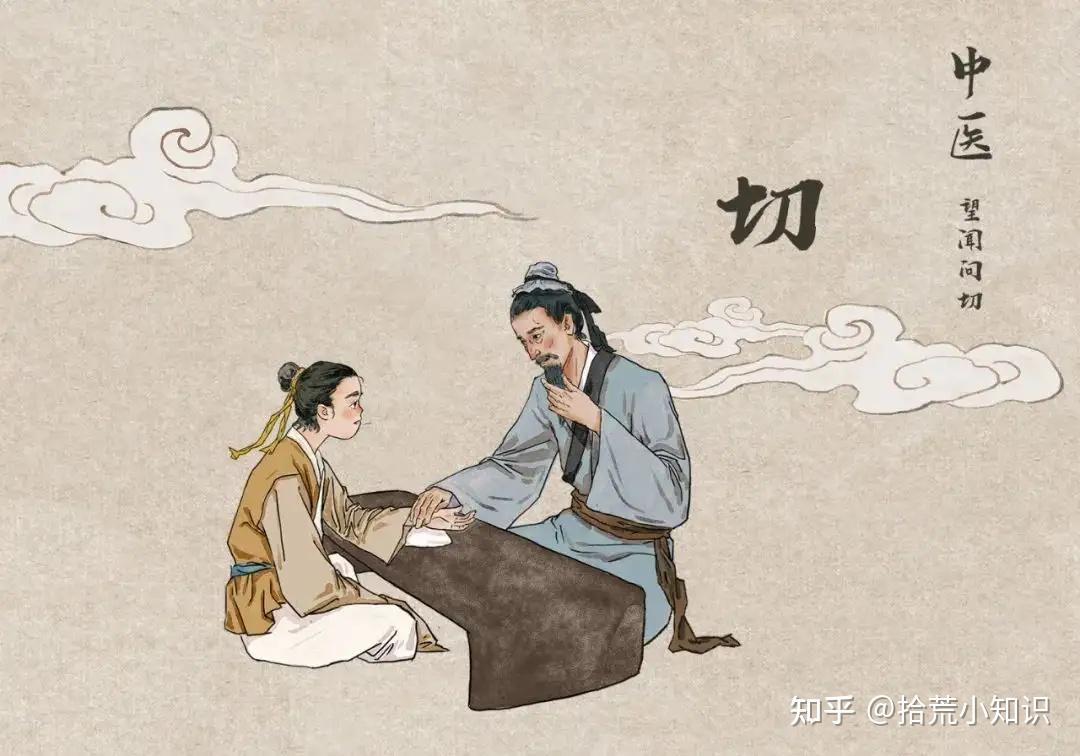]

# 五、多模态思维链？多模态融合？
1望诊...........         
2闻诊...........      
3问诊...........      
4切诊...........      
总结...........      

# “中国医药学是一个伟大的宝库，应当努力发掘，加以提高。” ——毛泽东
# “大力推动我国人工智能大模型发展。”——习近平